In [1]:
import tensorflow as tf
import numpy as np
import PIL.Image
from keras.models import Model
import functools
import IPython.display as display
import time

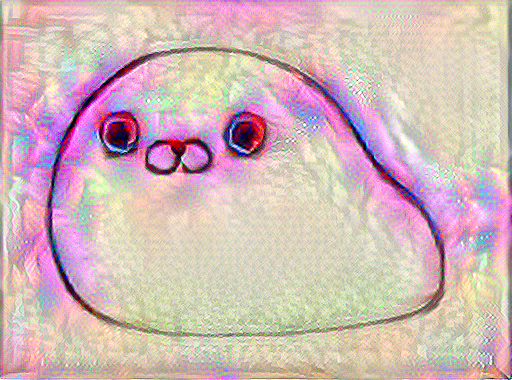

훈련 스텝: 250
전체 소요 시간: 504.7


In [3]:
content_path = ('C:/Users/user/Desktop/style-transfer-video-processor/img/mul.jpg')
style_path = ('C:/Users/user/Desktop/style-transfer-video-processor/img/spiderman.jpg')


content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

style_image = load_img(style_path)
content_image = load_img(content_path)


#model = Model(inputs, outputs)


def vgg_layers(layer_names):
  """ 중간층의 출력값을 배열로 반환하는 vgg 모델을 만듭니다."""
  # 이미지넷 데이터셋에 사전학습된 VGG 모델을 불러옵니다
  vgg = tf.keras.applications.VGG19( include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=max,
    classes=1000,
    classifier_activation="sigmoid") #include_top=False, weights='imagenet'
  vgg.trainable = False


  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)
style_image = load_img(style_path)
# 각 층의 출력에 대한 통계량을 살펴봅니다
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  크기: ", output.numpy().shape)
  print("  최솟값: ", output.numpy().min())
  print("  최댓값: ", output.numpy().max())
  print("  평균: ", output.numpy().mean())


def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)


class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}




extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1) #tf.optimizers.SGD(learning_rate=0.01,
    #momentum=0.0,
    #nesterov=False,
    #name='SGD')
style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)




start = time.time()

epochs = 5 #10
steps_per_epoch = 50 #100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

tensor_to_image(image).save("C:/Users/user/Desktop/style-transfer-video-processor/style_ref/test1.png")

